# Recommendation

The task of recommendation is one of the most intuitive. By studying people's explicit preferences (through ratings) or implicit preferences (through observed behaviour), you can make recommendations on what one user may like by drawing similarities between the user and other users, or between the products they liked and other products.

There are mainly three types of recommender systems:
- **Demographic Filtering**: They offer generalized recommendations to every user, based on movie popularity and/or genre. The System recommends the same movies to users with similar demographic features. Since each user is different , this approach is considered to be too simple. The basic idea behind this system is that movies that are more popular and critically acclaimed will have a higher probability of being liked by the average audience.
- **Content Based Filtering**: They suggest similar items based on a particular item. This system uses item metadata, such as genre, director, description, actors, etc. for movies, to make these recommendations. The general idea behind these recommender systems is that if a person liked a particular item, he or she will also like an item that is similar to it.
- **Collaborative Filtering**: This system matches persons with similar interests and provides recommendations based on this matching. Collaborative filters do not require item metadata like its content-based filtering. Collaborative filtering models can recommend an item to userA based on the interests of a imilar userB.


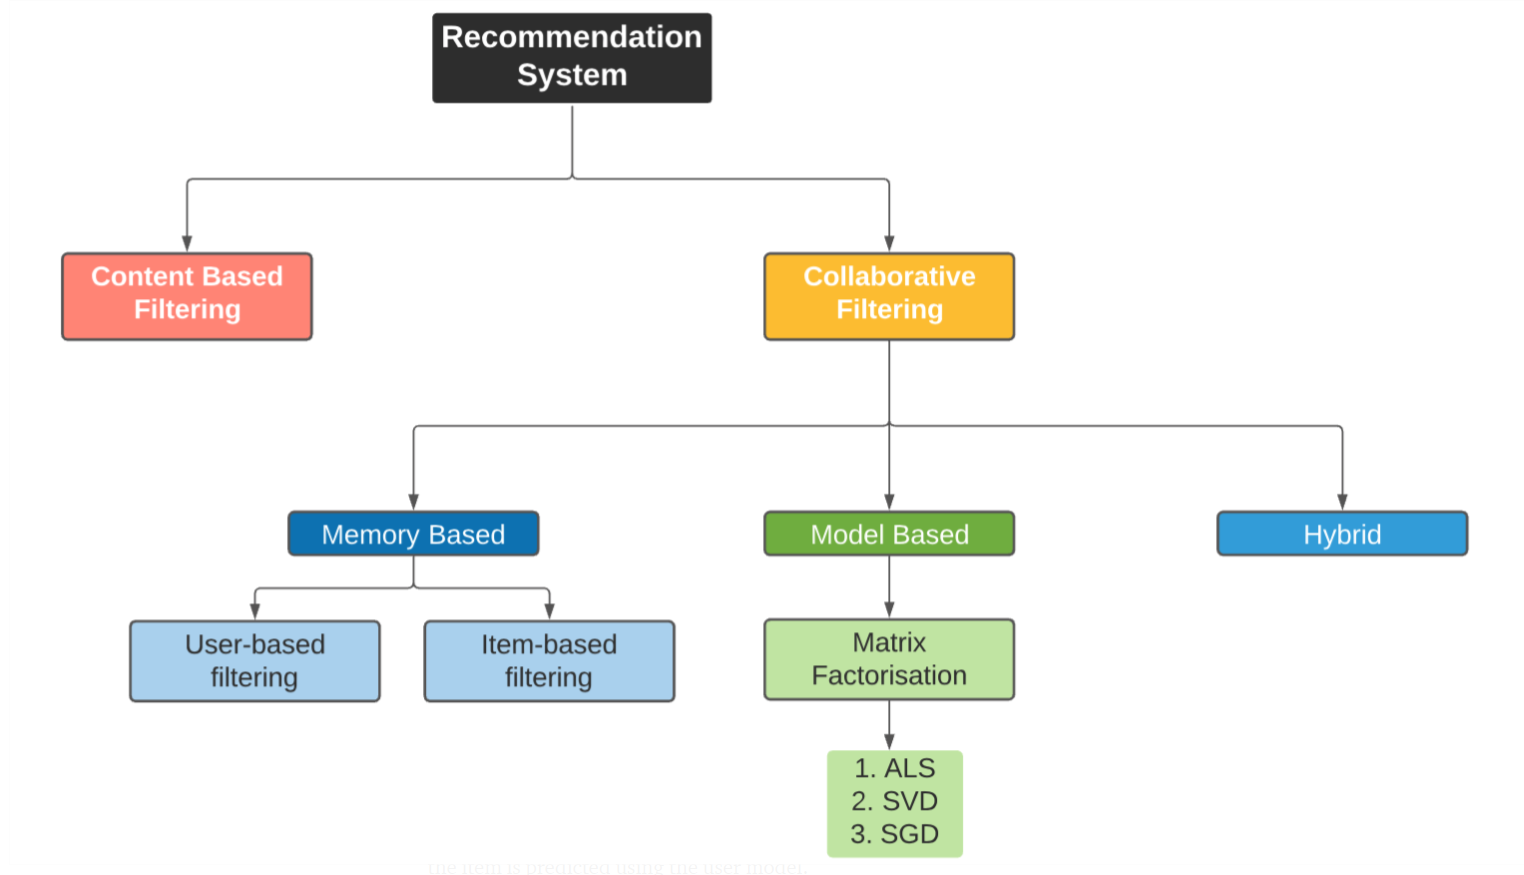


## Collaborative Filtering with Alternating Least Squares

- Alternating Least Squares (ALS) leverages a technique called **collaborative filtering**, which makes recommendations based only on which items users interacted with in the past.
- That is, it does not require or use any additional features about the users or the items.
- It supports several ALS variants (explicit or implicit feedback).
- Apart from ALS, Spark provides **Frequent Pattern Mining** for finding association rules in market basket analysis.

**ALS**
- ALS finds a k-dimensional feature vector for each user and item. The dot product of these vectors approximates the user's rating for that item.
- Therefore this only requires an input dataset of existing ratings between user-item pairs. (user id, item id, rating)
    - The ratings can either be ***explicit** (a numerical rating that we aim to predict directly) or **implicit** (each rating represents the strength of interactions observed between a user and item, such as number of likes), which measures our level of confidence in the user's preference for that item.
- Given this input DataFrame, the model will produce feature vectors that you can use to predict users' ratings for items they have not yet rated.


**Sensivity to Cold Start Problem**
- This algorithm does have a preference for serving things that are very common or that it has a lot of information on.
- If you are introducing a new product that no users have expressed a preference for, the algorithm is not going to recommend it to many people.
- Additionally, if new users are onboarding onto the platform, they may not have any ratings in the training set. Therefore, the algorithm won't know what to recommend them.
- These are examples of what we call the **cold start** problem.


**Cold-Start Strategy**
- When making predictions using an ALSModel, it is common to encounter users and/or items in the test dataset that were not present during training the model. (ex: user 1 is in training dataset, but not present in test dataset). This typically occurs in two scenarios:
1. In production, for new users or items that have no rating history and on which the model has not been trained (this is the **cold-start problem**)
2. During cross-validation, the data is split between training and evaluation sets. When using simple random splits as in Spark's CrossValidator or TrainValidationSplit, it is actually very common to encounter users and/or items in the evaluation set that are not in the training set.

- <span style='color:red'>By default, Spark assigns NaN predictions during ALSModel.transform when a user and/or item factor is not present in the model.</span> This can be useful in a production system, since it indicates a new user or item, and so the system can make a decision on some fallback to use as the prediction.
- However, this is undesirable during cross-validation, since any NaN predicted values will result in NaN results for the evaluation metric (for example when using RegressionEvaluator). This makes model selection impossible.
- Spark allows users to set the coldStartStrategy parameter to “drop” in order to drop any rows in the DataFrame of predictions that contain NaN values. The evaluation metric will then be computed over the non-NaN data and will be valid. Usage of this parameter is illustrated in the example below.
    - **drop**: if the user and/or item is new, model.transform method returns empty dataframe.
    - **nan**: if the user and/or item is new, model.transform method returns a dataframe in which user,movie, actual rating, and predictions present.However, all the predictions are NaN.


## Hyperparameters

These are configurations that we can specify to determine the structure of the model as well as the specific collaborative filtering problem we wish to solve:
- **numUserBlocks** is the number of blocks used to paralleize computation (set to -1 to auto-configure)
- **rank**: is the number of features to use. determines the dimension of the feature vectors learned for users and items. This should normally be tuned through experimentation. The core trade-off is that by specifying too high a rank, the algorithm may overfit the training data; bıt by specifying a low rank, then it may not make the best possible predictions. The default values is 10.
- **maxIter**: is the number of iterations of ALS to run. ALS typically converges to a reasonable solution in 20 iterations or less.
- **regParam**: specifies the regulazation parameter in ALS. controls regularization to prevent overfitting. You should test out different values for the regularization parameter to find the optimal value for your problem. regParam less dependent on the scale of the dataset, so we can apply the best parameter learned from a sampled subset to the full dataset and expect similar performance.
- **implicitPrefs**: specifies whether implicit (true) or explicit (false). It depends on the data. If the data is based off passive endorsement of a product (say, via a click or page visit), then you should use implicit preferences. In contrast, if the data is an explicit rating (e.g., the user gave this restaurant 4/5 stars), you should use explicit preferences. Explicit preferences are the default.
- **alpha**: When training on implicit feedback (behavioral observations), the alpha sets a baseline confidence for preference. This has a default of 1.0 and should be driven through experimentation.

**Spark** is great tool in terms of scalability. The algorithm and implementation in MLlib can scale to millions of users, millions of items, and billions of ratings.

## Example

Consider a movie recommendation system in which the training data consists of a feedback matrix in which:

- Each row represents a user.
- Each column represents an item (a movie).

#### 1D Embedding

Suppose
- we assign to each movie a scalar in [-1,1] that describes whether the movie is for children (negative values) or adults (positive values)
- we assign a scalar to each user in [-1,1] that describes the user's interest in the children movies (closer to -1) or adult movies (closer to +1)

If user-item matches
- the product of the values should be higher (closer to 1)
If user-item does not match
- the product of the values should be lower (closer to -1)

In the below example, the third and fourth users have preferences that are well explained by this feature. The third user prefers movies for children and the fourth user prefers movies for adults. However, the first and second users' preferences are not well explained by this single feature. (single feature -> liking children or adult movies)

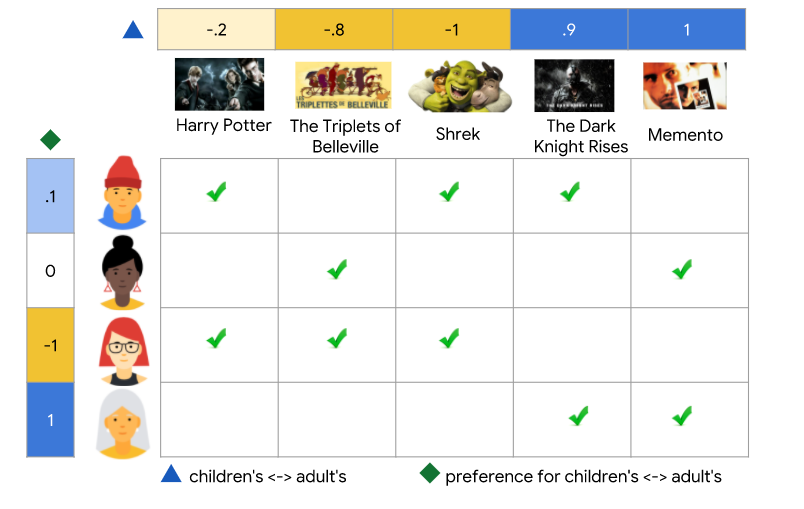

#### 2D Embedding

- one feature was not enough to explain the preferences of all users.
- To overcome this problem, second feature can be added (the degree to which each movie is a blockbuster or an arthouse movie)
- With a second feature, we can now represent each movie with the following two-dimensional embedding.

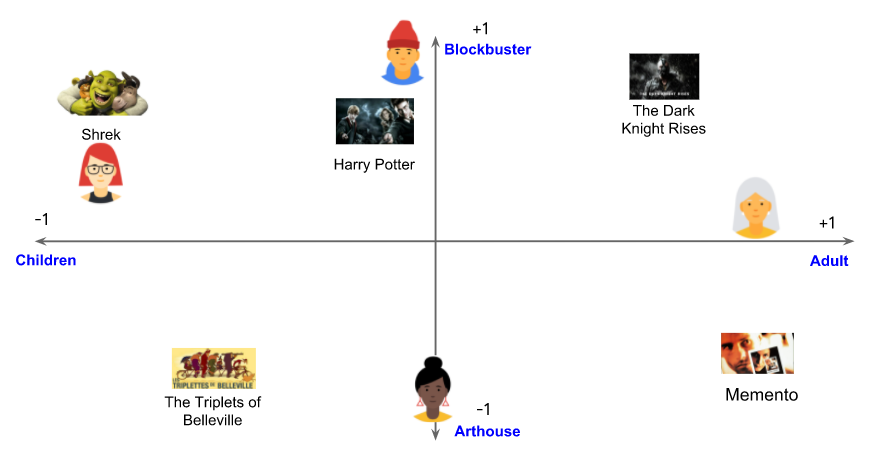

- For each (user,item) pair, we would like the dot product of the user embedding and the item embedding to be close to 1 when the user watched the movie, and 0 otherwise.

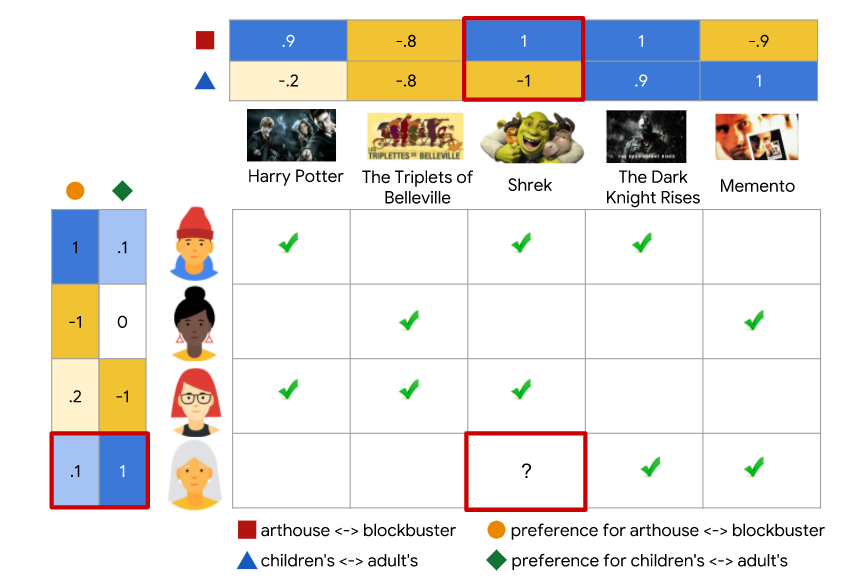

- In practice, the embeddings can be learned automatically, which is the power of **Collaborative filtering**
- There are different models to learn these embeddings, and how to train them.
- The collaborative nature of this approach is apparent when the model learns the embeddings. Suppose the embedding vectors for the movies are fixed. Then, the model can learn an embedding vector for the users to best explain their preferences. Consequently, embeddings of users with similar preferences will be close together. 
- Similarly, if the embeddings for the users are fixed, then we can learn movie embeddings to best explain the feedback matrix. As a result, embeddings of movies liked by similar users will be close in the embedding space.

## Matrix Factorization

Matrix factorization is a simple embedding model. Given the feedback matrix A (mxn),
- m: the number of users
- n: the number of items

The model learns U and V matrices.

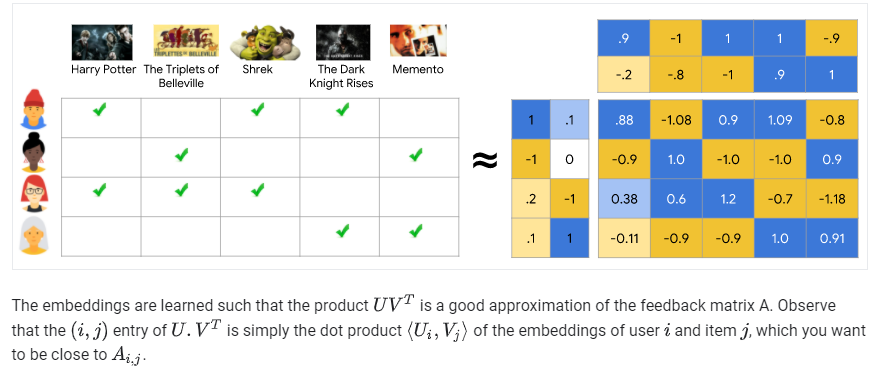

### Choosing the objective function

- One intuitive objective function is the squared distance. To do this, minimize the sum of squared errors over all pairs of observed entries:

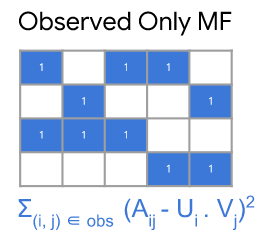

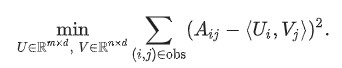

In this objective function, you only sum over **observed pairs** (i,j), that is, over non-zero values in the feedback matrix. However, only summing over values of one is not a good idea - a matrixx of all ones will have a minimal loss and produce a model that cant make effective recommendations and that generalizes poorly.

-------------

- Perhaps you could treat the unobserved values as zero, and sum over all entries in the matrix. This corresponds to minimizing the squared Frobenius distance between and its approximation UVt:

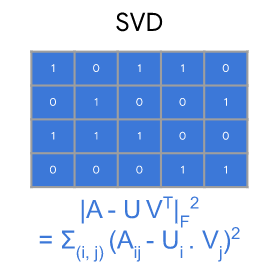

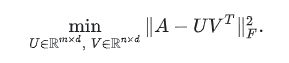

You can solve this quadratic problem through **Singular Value Decomposition (SVD)** of the matrix. However, SVD is not a great solution either, because in real applications, the matrix A may be very sparse. For example, think of all the videos on YouTube compared to all the videos a particular user has viewed. The solution UVt (which corresponds to the model's approximation of the input matrix) will likely be close to zero, leading to poor generalization performance.

--------------------------------

- **Weighted Matrix Factorization** decomposes the objective into the following two sums:
    - sum over observed entries
    - sum over unobserved entries (treated as zerous)
    
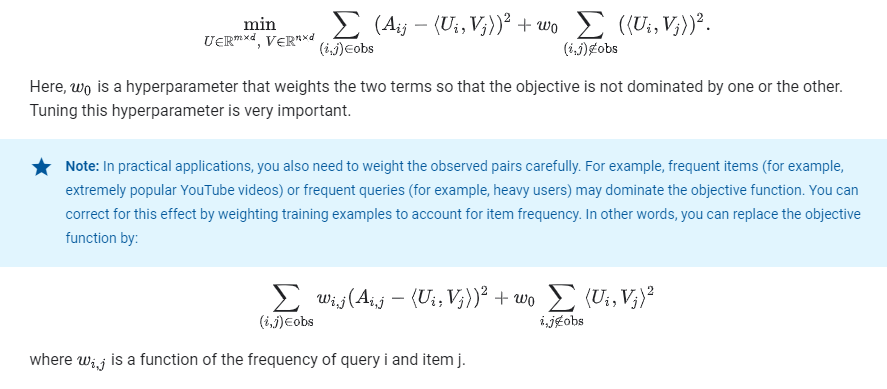


### Minimizing the Objective Function

Common algorithms to minimize the objective function include
- Stochastic gradient descent (SGD) is a generic method to minimize loss functions
- Weighted Alternating Least Squares (WALS) is specialized to this particular objective.

The objective is quadratic in each of the two matrices U and V. WALS works by initializing the embeddings randomly, then alternating between
- Fixing U and solving for V.
- Fixing V and solving for U.

Each stage can be solved exactly and can be distributed. This technique is guaranteed to converge because each step is guaranteed to decrease the loss.

### SGD vs WALS

**SGD**
- Very flexible - can use other loss functions.
- Can be parallelized.
- Slower - does not converge as quickly.
- Harder to handle the unobserved entries (need to use negative sampling or gravity)

**WALS**
- Reliant on Loss Squares only.
- Can be parallized.
- Converges faster than SGD.
- Easier to handle unabserved entries.

## Collaborative Filtering

**Advantages**
- No domain knowledge necessary.
    - Because the embeddings are automatically learned.
- Serendipity
    - The model can help users discover new interests. In isolation, the ML system may not know the user is interested in a given item, but the model might still recommend it because similar users are interested in that item.
- Great starting point
    - To some extent, the system needs only the feedback matrix to train a matrix factorization model. In particular, the system does not need contextual features. In practice, this can be used as one of multiple candidate generators.
    
**Disadvantages**
- Cannot handle fresh items.
    - The prediction of the model for a given (user, item) pair is the dot product of the corresponding embeddings. So, if an item is not seen during training, the system can't create an embedding for it and can't query the model with this item. This issue is often called the cold-start problem. However, the following techniques can address the cold-start problem to some extent:
        - **Projection in WALS**. Given a new item i0 not seen in training, if the system has a few interactions with users, then the system can easily compute an embedding vi0 for this item without having to retrain the whole model. The system simply has to solve the following equation or the weighted version. The below equation corresponds to one iteration in WALS: the user embeddings are kept fixed, and the system solves for the embedding of item i0. The same can be done for a new user. 
        
         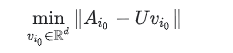
           
        - **Heuristics to generate embeddings of fresh items**. If the system does not have interactions, the system can approximate its embedding by averaging the embeddings of items from the same category, from the same uploader (in YouTube), and so on.
        
        
- **Hard to include side features for user/item**
Side features are any features beyond the query or item ID. For movie recommendations, the side features might include country or age. Including available side features improves the quality of the model. Although it may not be easy to include side features in WALS, a generalization of WALS makes this possible.
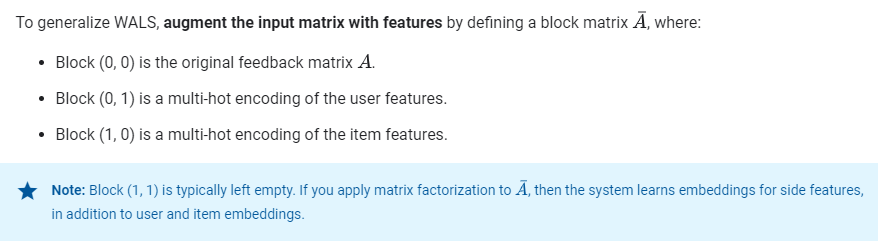

#### References

- Chambers, B., & Zaharia, M. (2018). Spark: The Definitive Guide. O'Reilly Media, Inc
- Google Developers - https://developers.google.com/machine-learning/recommendation/collaborative/basics